## Loading of Stringer orientations data

includes some visualizations

In [ ]:
#@title Install last pymc3 and import dependencies
# Import libraries
! pip install pymc3==3.8
! pip install arviz


import numpy as np
import scipy.stats

import sklearn.decomposition 
import sklearn.model_selection
import sklearn.pipeline
import sklearn.linear_model
import sklearn.metrics

import matplotlib
import seaborn as sns

import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import statsmodels.nonparametric.smoothers_lowess


     |████████████████████████████████| 911kB 4.5MB/s 
     |████████████████████████████████| 1.5MB 34.5MB/s 
     |████████████████████████████████| 4.3MB 43.1MB/s 
     |████████████████████████████████| 296kB 41.2MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title Figure Settings

#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 10]
# rcParams['font.size'] =15
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# rcParams['figure.autolayout'] = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


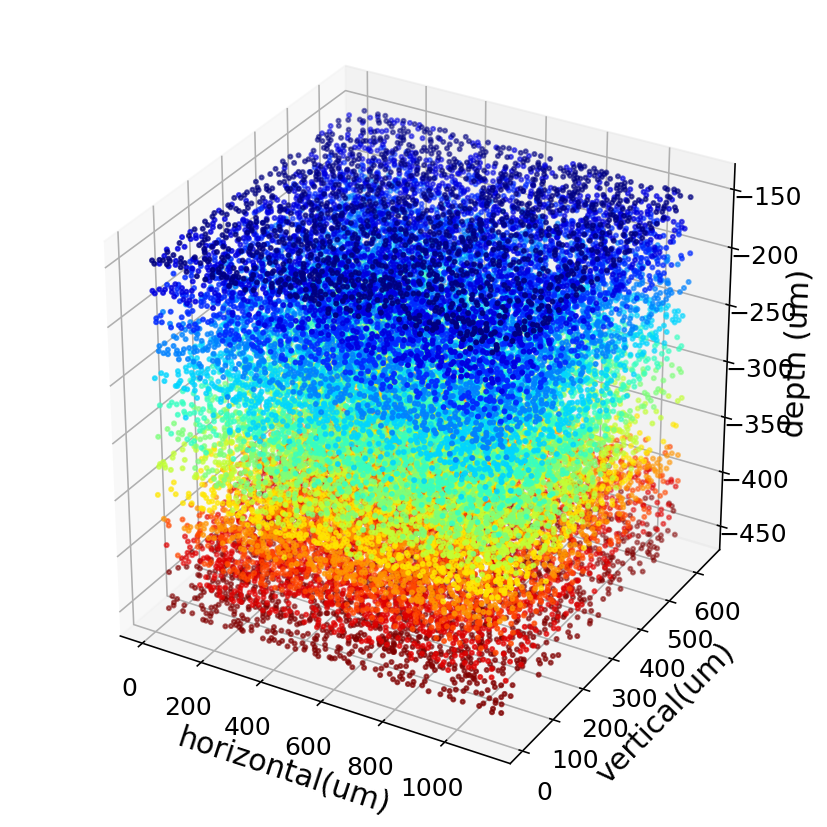

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

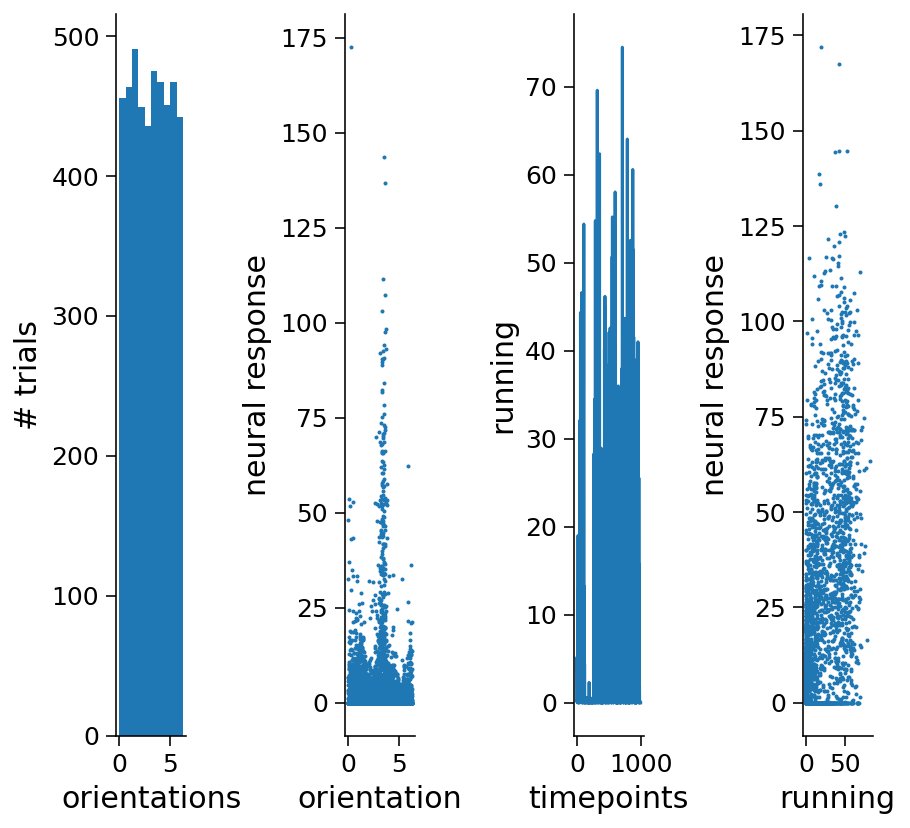

In [ ]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()


In [ ]:
#@title Preprocess data

# Load the angle data
istim = np.copy(dat['istim'])
# Center it at 0
istim -= np.pi

# Discretize it. Needed?
n_angle_bins = 360
span = 2 * np.pi / n_angle_bins
istim_bin = istim // span
istim_bin = istim_bin * 2 * np.pi / 360

# Load run and put both together in
# the X array (predictor variables) 
run = dat['run']
X = np.hstack([istim_bin[:, np.newaxis], run[:, np.newaxis]])

# Load neural activity and transpose it so it has dimensions
# n_trials x n_neurons 
sresp = dat['sresp'].T

In [ ]:
# @title Split into training and test sets
train_size = 0.7
rng = np.random.RandomState(2020)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, sresp, train_size=train_size, random_state=rng)
mus =  np.mean(y_train, axis=0)
sigmas = np.std(y_train, axis=0)

In [ ]:
# @title PCA with 3 components
K=3
pca = sklearn.decomposition.PCA(n_components=K)
y_train_pca = pca.fit_transform(y_train)

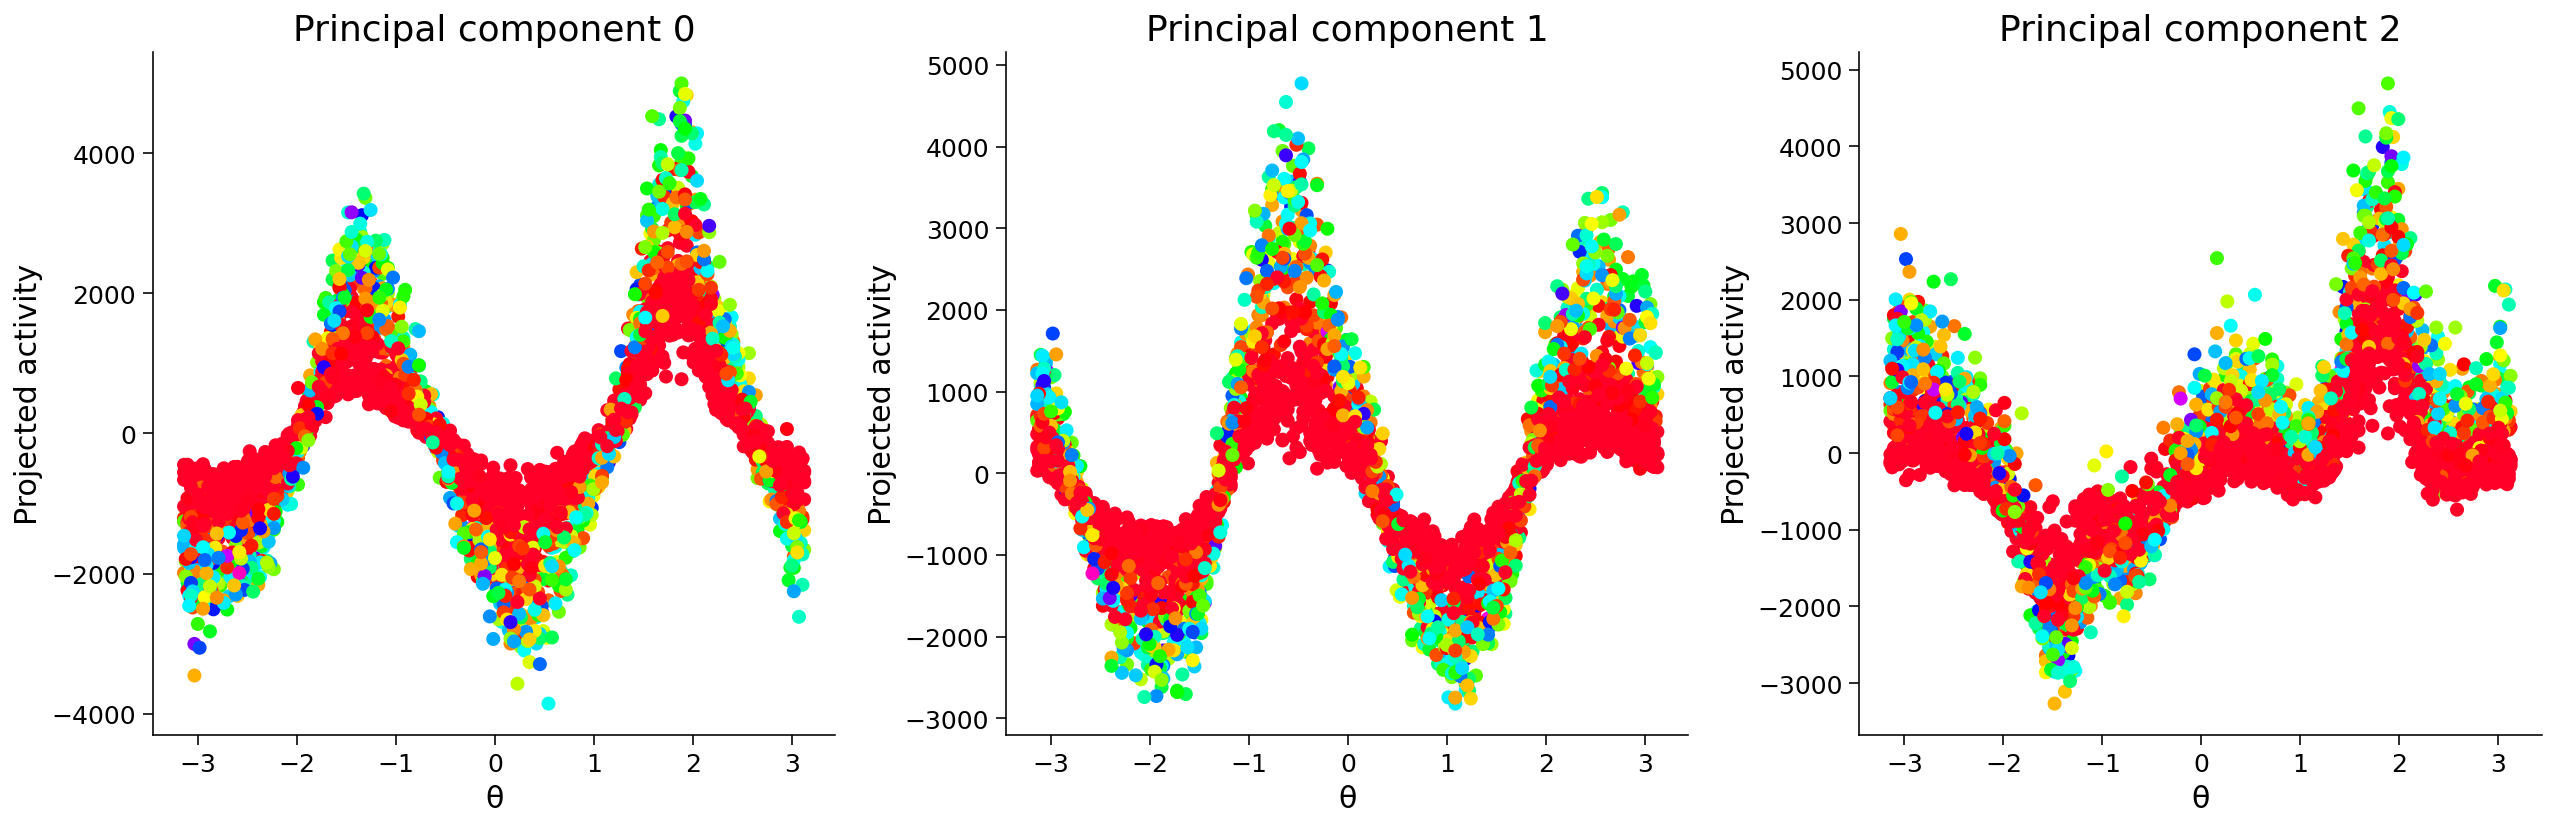

In [ ]:
# @title Plot the projected activity on each PC along the input angles
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
  ax[i].scatter(x = X_train[:, 0], y = y_train_pca[:,i], c=X_train[:,1], cmap="gist_rainbow")
  ax[i].set_title("Principal component " + str(i))
  ax[i].set_xlabel("θ")
  ax[i].set_ylabel("Projected activity")

In [ ]:
# @title Zscore neural activity data
print("""
    So we can compare activity across neurons,
    in units of standards deviations of each neuron's mean
    """)
y_train = scipy.stats.zscore(y_train, axis=0)


    So we can compare activity across neurons,
    in units of standards deviations of each neuron's mean
    


In [ ]:
# @title PCA with 3 components
print("The activity is now measured in units of standard deviations from the mean of each neuron")
K=9
pca = sklearn.decomposition.PCA(n_components=K)
y_train_pca = pca.fit_transform(y_train)

The activity is now measured in units of standard deviations from the mean of each neuron


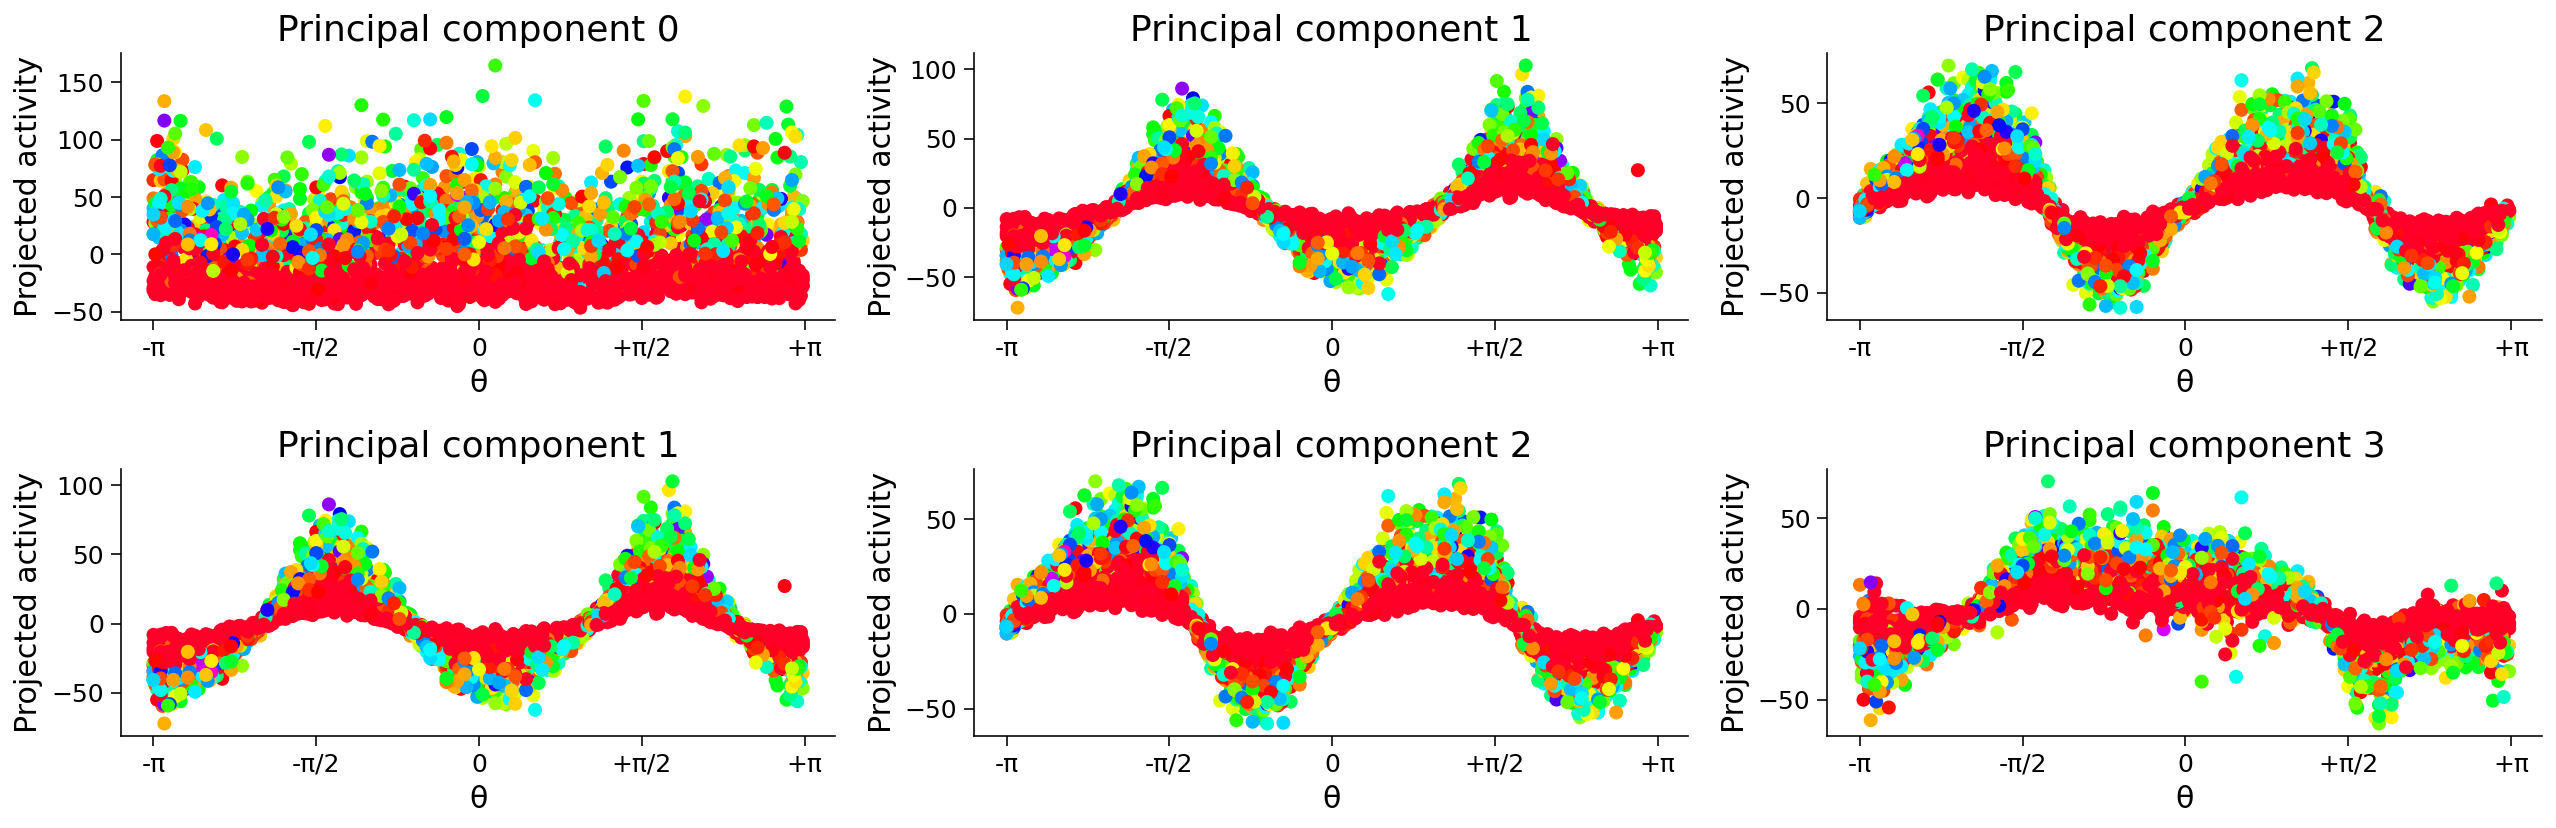

In [ ]:
# @title Plot the projected activity on each PC along the input angles
fig, ax = plt.subplots(2, 3, figsize=(18, 6))
for i in range(2):
  for j in range(3):
    ax[i,j].scatter(x = X_train[:, 0], y = y_train_pca[:,(i+j)], c=X_train[:,1], cmap="gist_rainbow")
    ax[i,j].set_title("Principal component " + str(i+j))
    ax[i,j].set_xlabel("θ")
    ax[i,j].set_ylabel("Projected activity")
    ax[i,j].set_xticks(ticks = [-np.pi, -np.pi/2, 0, +np.pi/2, +np.pi])
    ax[i,j].set_xticklabels(labels = ['-π', '-π/2', '0', '+π/2', '+π'])

After preprocessing the data and performing a PCA, we observe a beautiful pattern arise: the data lives in a subspace formed by cosine waves!
The first component does not, but it is only a by product of the zscoring step.
There is a second interesting pattern: as the mouse increases its speed, the activity moves away from 0 (from the mean). This is shown by the red dots, which represent a standing mouse (running speed of 0) and the rainbow of colors, which represent increasing speeds.


This is also True for the individual neurons when they show any pattern at all. Here we show a random sample

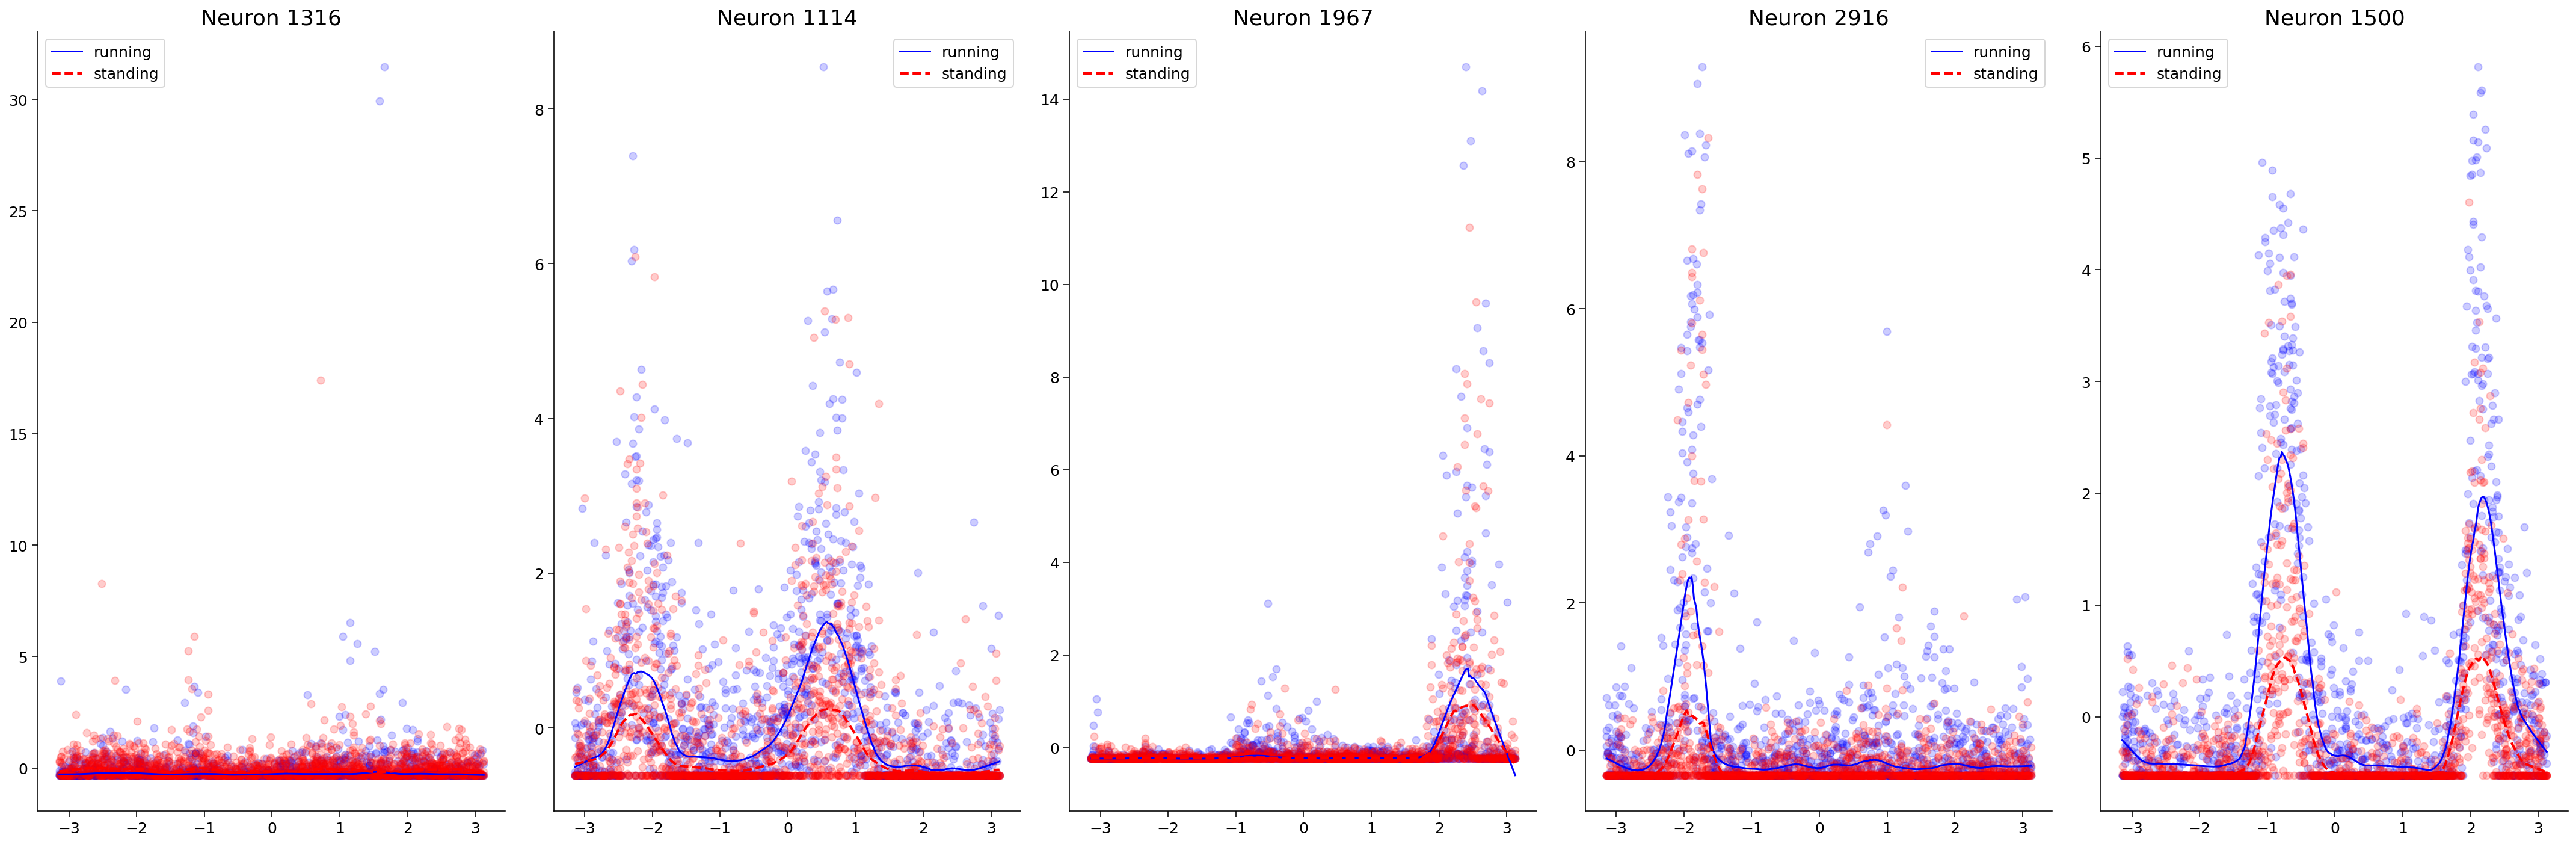

In [ ]:
# @title Plot for several neurons
def plot_single_neuron(x, y, neuron_idx, ax=None, running_threshold=2, min_activity=0.05):
    """
    Plot the activity of neuron #neuron_idx across all angles
    Segregate by running status (given by running_threshold)
    Standing trials are colored red and active blue
    A lowess is fit to each group of trials (standing / running)

    """
    if ax is None:
      fig, ax = plt.subplots(1, 1)
      # ax = ax[0,0]

    data = np.column_stack([x[x[:, 1] > running_threshold, 0], y[x[:, 1] > running_threshold, neuron_idx]])
    smooth = statsmodels.nonparametric.smoothers_lowess.lowess(endog = data[:, 1], exog = data[:, 0], frac=0.1)
    ax.scatter(data[:, 0], data[:, 1], c = "blue", alpha = 0.2)
    ax.plot(smooth[:, 0], smooth[:, 1], "-b", label = "running")

    data = np.column_stack([x[x[:, 1] <= running_threshold, 0], y[x[:, 1] <= running_threshold, neuron_idx]])
    smooth = statsmodels.nonparametric.smoothers_lowess.lowess(endog = data[:, 1], exog = data[:, 0], frac=0.1)
    ax.scatter(data[:, 0], data[:, 1], c = "red", alpha = 0.2)
    ax.plot(smooth[:, 0], smooth[:, 1], "--r", label = "standing", linewidth=2)

    ax.legend()
    ax.set_title(f"Neuron {neuron_idx}")

neurons = np.random.choice(a=np.arange(y_train.shape[0]), size=4)
neurons = np.append(neurons, 1500) # I like how neuron #1500 looks :P


fig, ax = plt.subplots(1, 5, figsize = (30, 10))
for idx, neuron_idx in enumerate(neurons):
  plot_single_neuron(X_train, y_train, neuron_idx, ax[idx])

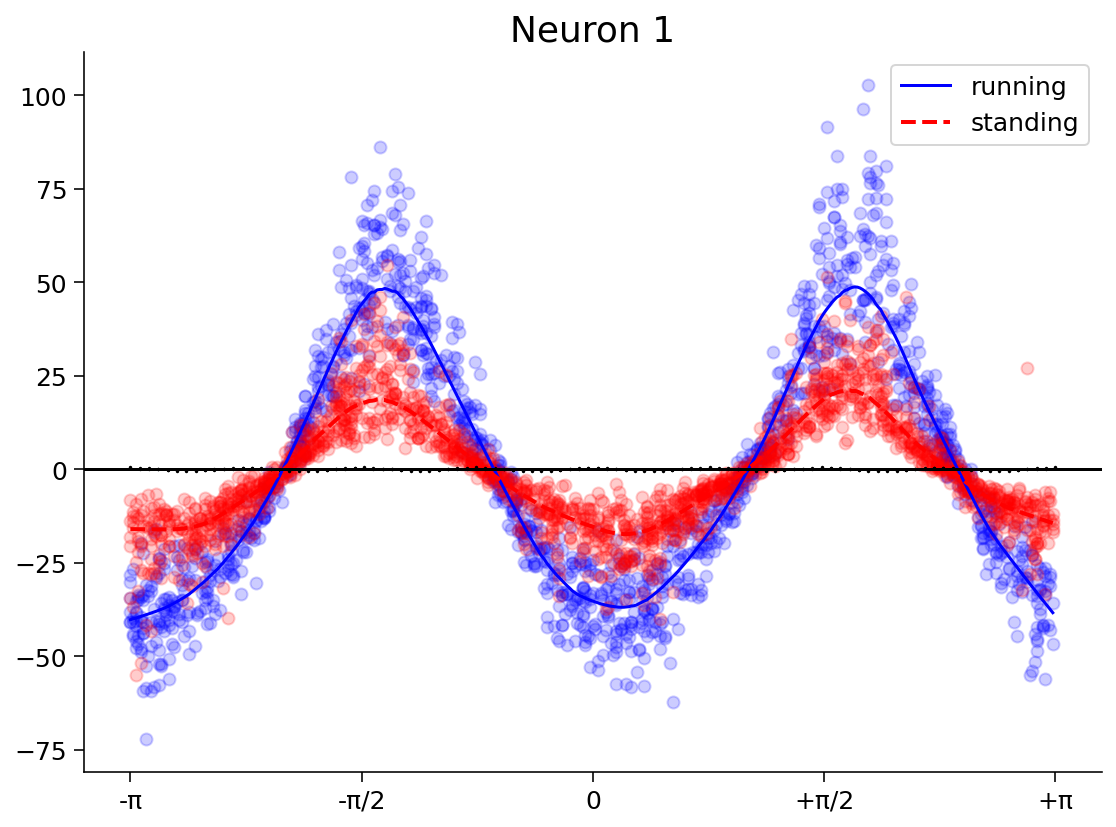

In [ ]:
# @title Plot first cosine PC and fit loess curve for visualization
neuron_idx = 1
xmax =  [np.max(X_train[:, 0]), np.pi]
plot_single_neuron(X_train, y_train_pca, neuron_idx)
linspace = np.linspace(np.min(X_train[:, 0]), xmax[i], 100)
plt.scatter(linspace, np.cos(8 * linspace) / 2, s=.5, c="black")
plt.scatter(linspace, np.cos(8 * linspace) / 4, s=.5, c="black")
plt.axhline(y=0, xmin=0, xmax=1, c="black")
plt.legend()
_ = plt.xticks(
    ticks = [-np.pi, -np.pi/2, 0, +np.pi/2, +np.pi],
    labels = ['-π', '-π/2', '0', '+π/2', '+π']
    )

In [ ]:
#@title Massage the data

class DataFormatter:

    def __init__(self, x, y):
        self._x = x
        self._y = y

    def sort(self, index=0):
        """
        Sort the rows by increasing indexth column in X
        By default index is 0 so it's by angle
        """
        index = np.argsort(self._x[:,index])
        self._x = self._x[index,:]
        self._y = self._y[index,:]

    def fold(self, factor=4):
        """
        Fold the angles so they only go from - pi/4 to pi/4
        to avoid having several peaks
        This will do estimation of the running effect easier
        """
        self._x[:, 0] = self._x[:, 0] % np.pi/factor

    def max_norm(self):
        max_y = self._y.max(axis=0)
        self._y /= max_y

    def flip(self):
        self._y = 1 - self._y

    def demean(self):
        mean_y = self._y.mean(axis=0)
        self._y -= mean_y

    def fold_flip(self, factor=4):
        x = np.copy(self._x)
        index = x[:, 0] < np.pi/(factor*2)
        x[index, 0] = x[index, 0] + np.pi/factor
        self._x = x

    def decos(self):

      # self._y = self._y / np.cos(2*np.pi/8 - self._x[:, 0])[:, np.newaxis]
        self._y = np.arccos(self._y)


    def data(self):
      return (self._x, self._y)


    def pipeline(self):
      df.sort()
      df.fold()
      df.max_norm()
      df.flip()
      df.demean()
        
x = np.copy(X_train)
y = np.copy(y_train_pca)

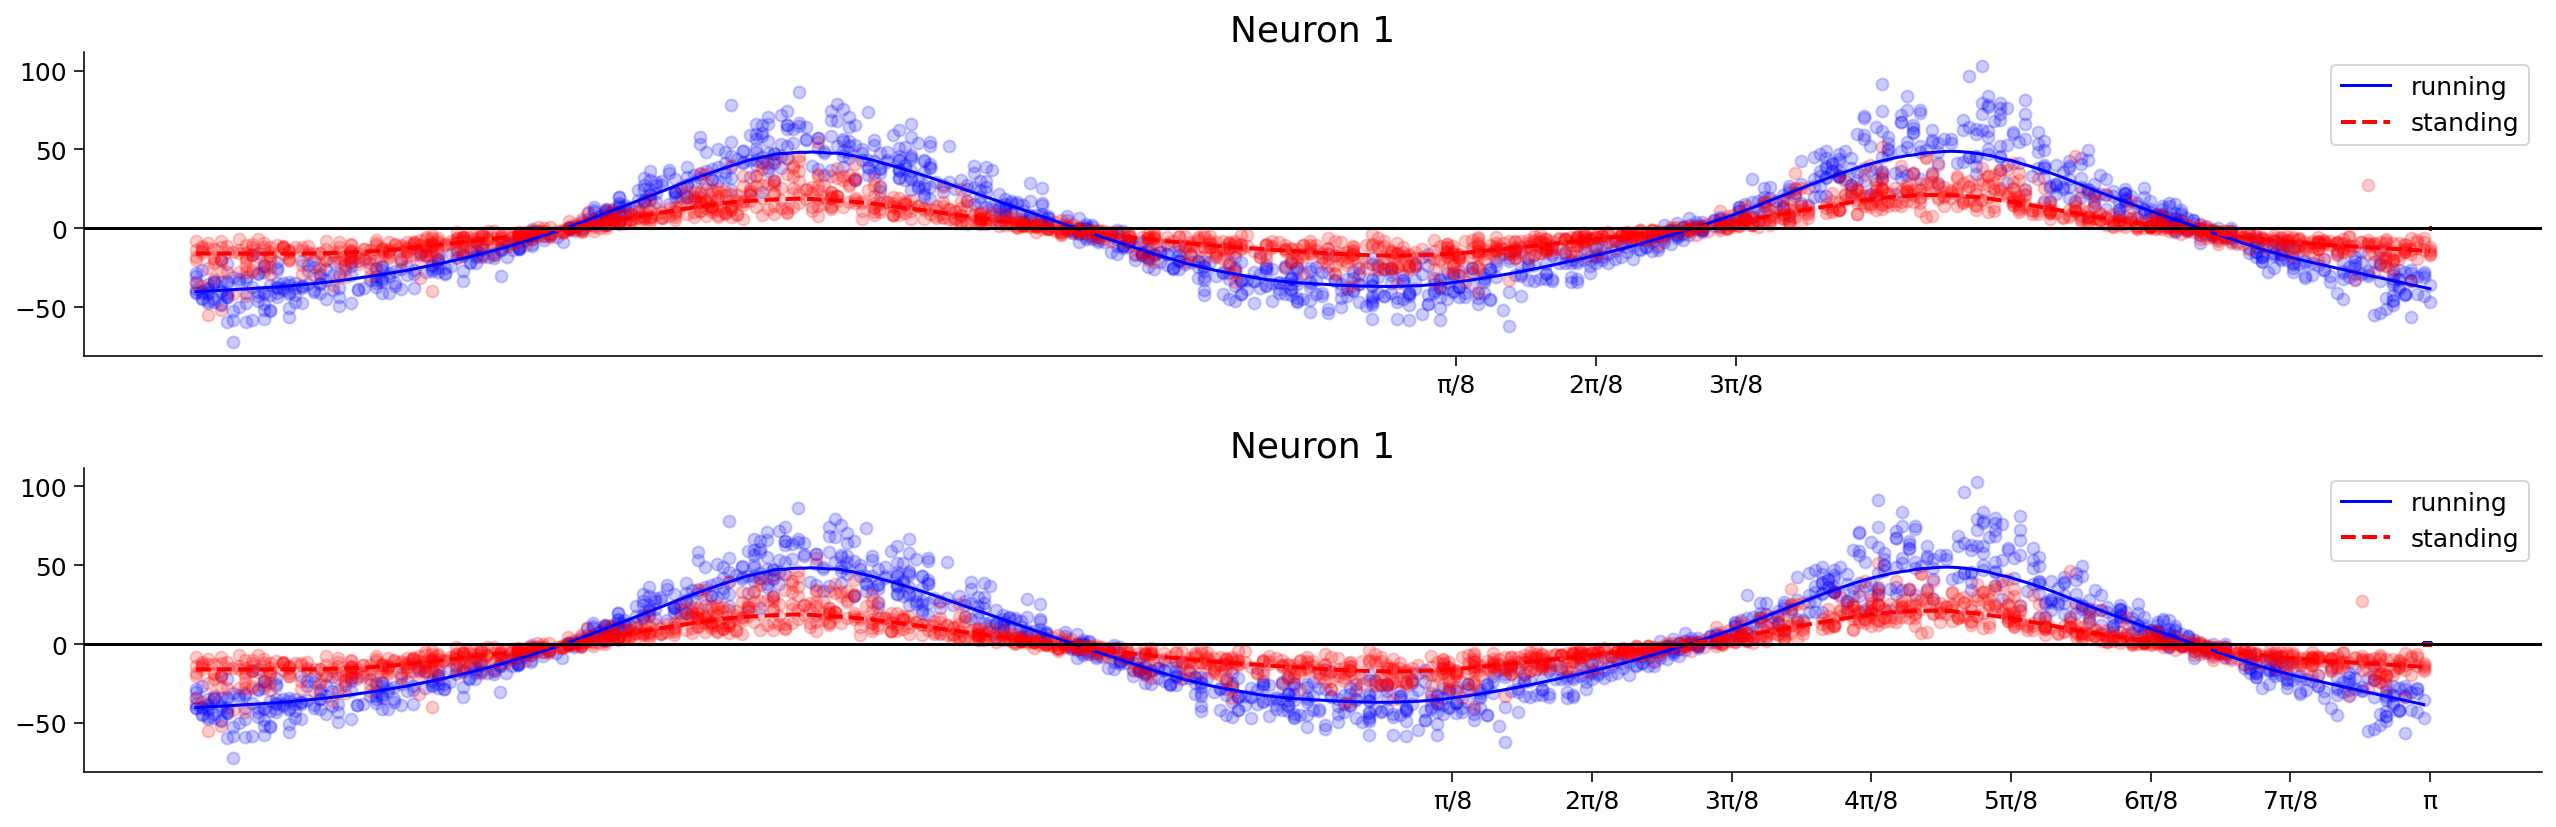

In [ ]:
# @title Plot processed PC and LOWESS fit
fig, ax = plt.subplots(2, 1, figsize=(18, 6))
xmax =  [np.max(x[:, 0]), np.pi]
xaxis = [
          [
           [np.pi/8, np.pi/4, 3*np.pi/8],
           ['π/8', '2π/8', '3π/8']],
          [
           [np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, np.pi],
           ['π/8', '2π/8', '3π/8', '4π/8', '5π/8', '6π/8', '7π/8', 'π']
          ]
        ]
neuron_idx = 1
for i in range(2):
  plot_single_neuron(x, y, neuron_idx, ax=ax[i])
  linspace = np.linspace(xmax[0], xmax[i], 500)
  ax[i].scatter(linspace, np.cos(8 * linspace) / 2, s=1, c="blue")
  ax[i].scatter(linspace, np.cos(8 * linspace) / 4, s=1, c="red")
  ax[i].axhline(y=0, xmin=0, xmax=1, c="black")
  ax[i].legend()
  ax[i].set(xticks=xaxis[i][0], xticklabels=xaxis[i][1])


* Fold the x axis so only one cycle and not two are present in the data
* Make the activity go up to 1 or down to -1
* Demean

In [ ]:
df = DataFormatter(x, y)
df.pipeline()
x, y = df.data()

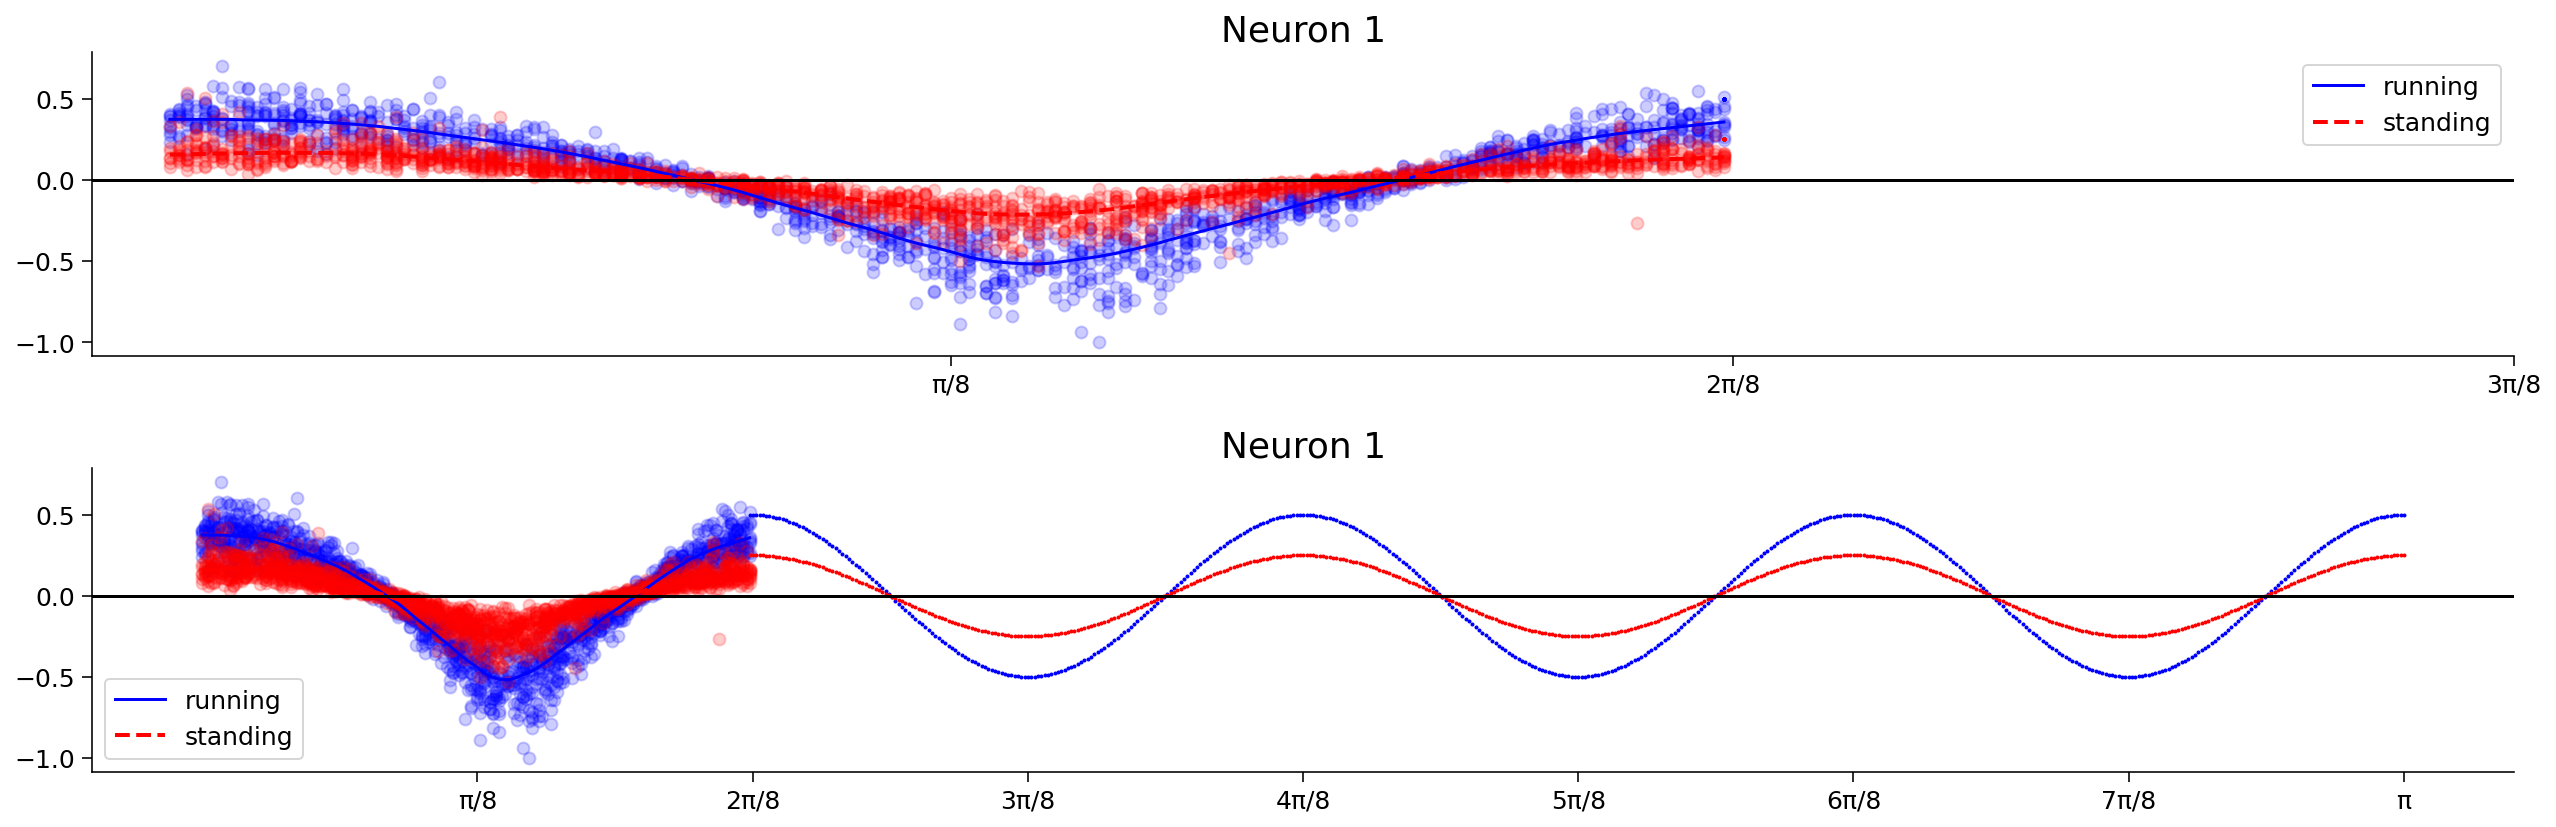

In [ ]:
# @title Plot processed PC and LOWESS fit
fig, ax = plt.subplots(2, 1, figsize=(18, 6))
xmax =  [np.max(x[:, 0]), np.pi]
xaxis = [
          [
           [np.pi/8, np.pi/4, 3*np.pi/8],
           ['π/8', '2π/8', '3π/8']],
          [
           [np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, np.pi],
           ['π/8', '2π/8', '3π/8', '4π/8', '5π/8', '6π/8', '7π/8', 'π']
          ]
        ]
neuron_idx = 1
for i in range(2):
  plot_single_neuron(x, y, neuron_idx, ax=ax[i])
  linspace = np.linspace(xmax[0], xmax[i], 500)
  ax[i].scatter(linspace, np.cos(8 * linspace) / 2, s=1, c="blue")
  ax[i].scatter(linspace, np.cos(8 * linspace) / 4, s=1, c="red")
  ax[i].axhline(y=0, xmin=0, xmax=1, c="black")
  ax[i].legend()
  ax[i].set(xticks=xaxis[i][0], xticklabels=xaxis[i][1])


We have given the data the shape we wanted: we can now approximate it as a cosine wave that makes 4 cycles within the interval 0 to $\pi$ i.e. 8 cycles in [$-\pi$ to $\pi$]. This will make modelling much easier, as now all we have to do **is estimate how much stronger one cosine wave is compared to the other**.
To achieve this, we will describe a probabilistic model of how the activity is generated in the neuron that will include a parameter reflecting the differential strength



Throughout this explanation, I will be referring to the PC-projected and processed neural activity, as neural activity. Even though they are not the same, the former contains most of the properties that make the latter interesting, while making it much easier to analyze. In particular, it conserves the same pattern of intensified activity as the mouse runs.

The model will try to predict the activity based on the running speed and the angle. For this it will:

I) Compute the difference between the presented angle $\theta_{in}$ and the reference angle $\theta_{ref}$. If this difference is 0, the activity should be maximum. And the bigger it is the smaller the activity, down to the most negative value

II) Define an effect or strength parameter that multiplies the cosine wave so we get back the neural activity

We will fit two models to these data: one with a single strength parameter for all trials and another one which will differentiate between trials where the mouse is running and where it is not, and attempt to fit each parameter to the corresponding data.

The fitting is done by approximating the posterior distribution of the strength and a few other parameters governing the probabilities in the model via Markov Chain Monte Carlo (MCMC).

PyMC3 provides the modelling framework and the MCMC samplers, like NUTS (No U-Turn Sampler).

In [ ]:
# @title Helper Bayesian modelling classes
class BayesEstimator:

    # Class attributes: they do not change in the different objects

    # minimum activity to be considered in the analysis
    _threshold = 0.1

    def __init__(self, predictor: np.array, response: np.array):

      # Data
      if predictor.shape[0] != response.shape[0]:
        raise Exception(
            f"""
            Number of datapoints in predictor ({predictor.shape[0]})
            and response ({response.shape[0]}) do not match
            (but they have to!)
            """)
      
      self._predictor = predictor
      self._response = response
      self._neuron_idx = 0

      # Placeholders for PyMC3 results
      self._model = None
      self._trace = None


    @property
    def non_missing(self):
        """
        Return the index of trials where the activity for the selected
        neuron_idx is more than the threshold
        Only a single neuron can be analyzed this way
        """
        result = self._response[:, self._neuron_idx] > self._threshold
        keep = np.sum(result)
        total = self._response.shape[0]
        
        if keep != total:
            print(f"WARNING - Keeeping {keep}/{total} trials. Th = {self._threshold}")
        
        return result

    @property
    def predictor(self):
        """
        Variable(s) that the class will use to estimate the response
        """
        # return self._predictor[self.non_missing, :]
        return self._predictor

    @property
    def response(self):
        """
        Response data to be modelled as a function of the predictor
        """
        
        if self._neuron_idx is None:
          raise Exception("neuron_idx is None. Please pass a valid neuron id")
        # return self._response[self.non_missing,  self._neuron_idx][:, np.newaxis]
        return self._response[:,  self._neuron_idx]
         
    def model(self):
        """
        This method should be redefined in inheriting classes
        and optionally call it when they finish
        to display this message 
        """
        print("Model compiled successfully!! ^-^")

    def sample(self, **kwargs):
        """
        Run MCMC and sample from the estimated posterior distribution
        of the model's parameters
        """
        if self._model is None:
            raise Exception("Please generate a model first")
        with self._model:
            self._trace = pm.sample(2000, tune=1000, **kwargs)

        return self._trace

    def load(self, neuron_idx):
        """
        Select a different neuron in the dataset
        """
        with self._model:
          pm.set_data({'response': self.response[:, neuron_idx][:, np.neuron_idx]})

    def plot(self, plot, var_names):
        """
        Wrapper around some common pymc3 plots
        """
        if plot == "trace":
            az.plot_trace(self._trace, var_names = var_names)

        elif plot == "forest":
            az.plot_forest(self._trace, var_names = var_names, combined = True)

        else:
            raise Exception("Please provide a valid plot name")

    def graph(self):
        """
        Produce an illustration of the model
        """
        pm.model_to_graphviz(self._model)

    def fit(self, n_iter):
        """
        Run Variational Inference instead of MCMC by maximizing the ELBO
        """
        
        if self._model is None:
            raise Exception("Please generate a model first")
        
        with self._model:
            advi = pm.ADVI()
            approx = advi.fit(n=n_iter)

            plt.plot(advi.hist)
            plt.legend()
            plt.title('ELBO')
            plt.xlabel('Iteration');
            plt.close()
            self._trace = trace=approx.sample(10000)


class NoAngleEffect(BayesEstimator):
    
    _running_threshold = 2


    def model(self):
        """
        Generate a Bayesian model using two predictor
        to predict the activity of one neuron
        """

        with pm.Model() as model:

            run = pm.Data('run', self.predictor[:, 1])
            activity = pm.Data('activity', self.response.flatten())
            
            # slope of the regression activity - diff between ref and input
            β_standing = pm.Normal('β_standing', mu = 0, sd=1)
            β_running = pm.Normal('β_running', mu = 0, sd=1)
            β_diff = pm.Deterministic('β_diff', β_running - β_standing)
            μ_ =  pm.Normal('μ_',  mu=2, sd=5) 
            
            μ =  pm.Deterministic('μ',  pm.math.switch(run > self._running_threshold,
                                                       μ_ + β_running,
                                                       μ_ + β_standing,
                                                       )) 
            σ = pm.HalfNormal('σ', sd=5)


            # The observed data follows a Normal distribution with
            # * mean given by the linear regression on the neuron
            # based on the presented angle
            # * a constant sigma
            y_pred = pm.Normal('y_pred', mu = μ, sd = σ, observed = activity)

        self._model = model


class RunningAddsNoise(BayesEstimator):

    def model(self):
        """
        Generate a Bayesian model using two predictor
        to predict the activity of one neuron
        """

        with pm.Model() as model:

            angle = pm.Data('angle', self.predictor[:, 0])
            run = pm.Data('run', self.predictor[:, 1])
            activity = pm.Data('activity', self.response.flatten())
            
            # the θ at which the neuron is most activeangle - θ
            # (the peak of the tuning curve) 
            θ = pm.Uniform('θ', lower=-np.pi, upper=+np.pi)

            # intercept of the regression activity - diff between ref and input
            # α = pm.Normal('α', mu = 0, sd=1)
            # slope of the regression activity - diff between ref and input
            α = pm.Normal('α', mu=0, sd=1)
            β = pm.Normal('β', mu = 0, sd=1)

            μ =  pm.Deterministic('μ',  pm.math.cos(angle - θ) * β) 
            # standard deviation of the activity (z scored)
            σ = pm.HalfNormal('σ', sigma=5)

            # the sigma of the observed values is computed by adding to a
            # prior noise an additive term that depends on the running speed
            # i.e. the more running speed, the more powerful this term is
            # if alpha is positive, more speed adds more noise
            # if alpha is negative, more speed removes noise
            sigma = pm.Deterministic('sigma', pm.math.maximum(1, σ + α * run))

            # The observed data follows a Normal distribution with
            # * mean given by the linear regression on the neuron
            # based on the presented angle
            # * a constant sigma
            y_pred = pm.Normal('y_pred', mu = μ, sd = sigma, observed = activity)

        self._model = model

class CosineModelWithoutRunningEffect(BayesEstimator):
    """
    A model to fit cosine waves to the activity of neurons
    This makes sense only on eigen neurons,
    as they are the only ones with that behavior
    """

    _exacerbation = 1
    _running_threshold = 2
    _cos_mult = 8
    _peak_angle = np.round(2*np.pi/8, decimals=3)
    # _peak_angle = 0.8

    def model(self):
        """
        Generate a Bayesian model using two predictor
        to predict the activity of one neuron
        """
        with pm.Model() as model:

            print(f"INFO - Loading predictor variables of shape {self.predictor.shape}")
            print(f"INFO - Loading response variables of shape {self.response.shape}")

            angle = pm.Data('angle', self.predictor[:, 0])
            run = pm.Data('run', self.predictor[:, 1])
            activity = pm.Data('activity', self.response.flatten())

            # Priors
            β = pm.Normal('β', mu=1, sd=1)           
            σ_ = pm.HalfNormal('σ_', 5)
            angle_diff = angle - self._peak_angle
            cosine_signal = pm.Deterministic('cosine_signal', pm.math.cos(self._cos_mult * angle_diff))

            σ = pm.Deterministic('σ', σ_ * pm.math.abs_(cosine_signal))           
            μ = pm.Deterministic('μ', cosine_signal * β)
        
            # The observed data follows a Normal distribution with
            # * mean given by the linear regression on the neuron
            # based on the presented angle
            # * a constant σ
            y_pred = pm.Normal('y_pred', mu = μ, sd = σ, observed = activity)

        self._model = model
        super().model()

class CosineModelWithRunningEffect(BayesEstimator):
    """
    A model to fit cosine waves to the activity of neurons
    This makes sense only on eigen neurons,
    as they are the only ones with that behavior
    """

    _exacerbation = 2
    _running_threshold = 2
    _cos_mult = 8
    _peak_angle = np.round(2*np.pi/8, decimals=3)

    def model(self):
        """
        Generate a Bayesian model using two predictor
        to predict the activity of one neuron
        """
        with pm.Model() as model:

            print(f"INFO - Loading predictor variables of shape {self.predictor.shape}")
            print(f"INFO - Loading response variables of shape {self.response.shape}")

            angle = pm.Data('angle', self.predictor[:, 0])
            run = pm.Data('run', self.predictor[:, 1])
            activity = pm.Data('activity', self.response.flatten())
            
            # Priors
            β_standing = pm.Normal('β_standing', mu=1, sd=1)
            β_running = pm.Normal('β_running', mu= 1 * self._exacerbation, sd=1)
            β_diff = pm.Deterministic('β_diff', β_running - β_standing)
            σ_ = pm.HalfNormal('σ_', 5)
            μ_ = pm.Normal('μ_', mu=0, sd=5)

            angle_diff = angle - self._peak_angle
            cosine_signal = pm.Deterministic('cosine_signal', pm.math.cos(self._cos_mult * angle_diff))

            σ = pm.Deterministic('σ', σ_ * pm.math.abs_(cosine_signal))
            μ = pm.Deterministic('μ', pm.math.switch(run > self._running_threshold,
                                                     cosine_signal * μ_ * β_running,
                                                     cosine_signal * μ_ * β_standing
                                                     ))
        
            # The observed data follows a Normal distribution with
            # * mean given by the linear regression on the neuron
            # based on the presented angle
            # * a constant σ
            y_pred = pm.Normal('y_pred', mu = μ, sd = σ, observed = activity)

        self._model = model
        super().model()

class SwitchingModel(BayesEstimator):
    _exacerbation = 2
    _running_threshold = 2

    # trials where the animal has > running_threshold AU of speed
    # the mouse is running, otherwise it is standing
   

    def model(self):
        """
        Generate a Bayesian model using two predictor
        to predict the activity of one neuron
        """

        with pm.Model() as model:

            print(f"INFO - Loading predictor variables of shape {self.predictor.shape}")
            print(f"INFO - Loading response variables of shape {self.response.shape}")

            angle = pm.Data('angle', self.predictor[:, 0])
            run = pm.Data('run', self.predictor[:, 1])
            activity = pm.Data('activity', self.response.flatten())

            # Priors
            # width = pm.math.minimum(0.1, pm.HalfNormal('width', sd=1))
            width = .5
            θ1 = pm.Uniform('θ1', lower=-np.pi, upper=+np.pi)
            θ2_temp = θ1 + width
            θ2 = pm.Deterministic('θ2', pm.math.switch(θ2_temp > np.pi, θ2_temp - 2*np.pi, θ2_temp))

            condition = pm.math.switch(θ1 < θ2,
                           pm.math.and_(θ1 < angle, θ2 > angle),
                           pm.math.and_(θ1 < angle, θ2 < angle)
            )

            σ = pm.HalfNormal('σ', 1)

            # mu rest
            μ_rest = pm.HalfNormal('μ_rest', sd=2)
            
            # mu spike
            # λ = pm.HalfNormal('λ', sd = 3)
            λ = 1
            μ_spike = pm.Exponential('μ_spike', lam=λ)
            
            # factor the running effect
            # coeff = 1 + pm.HalfNormal('coeff', sd = 1)
            exacerbation = pm.Deterministic('exacerbation',
                                            pm.math.switch(run > self._running_threshold,
                                                           self._exacerbation,
                                                           1
                                            
                                            )
            )

            μ = pm.math.switch(condition, μ_spike * exacerbation, μ_rest)          
            
            # The observed data follows a Normal distribution with
            # * mean given by the linear regression on the neuron
            # based on the presented angle
            # * a constant σ
            y_pred = pm.Normal('hypothesis', mu=μ, sd=σ, observed = activity)

        self._model = model

class NotSwitchingModel(SwitchingModel):
     _exacerbation = 1

In [ ]:
#@title Analysis of the first PC, which is angle independent
x = np.copy(X_train)
y = np.copy(y_train_pca)
df = DataFormatter(x, y)
x, y = df.data()
model_simple = NoAngleEffect(x, y)
model_simple._neuron_idx = 0
model_simple.model()
model_simple.sample(chains=2, target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ_, β_running, β_standing]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:38<00:00, 78.39it/s] 


<MultiTrace: 2 chains, 2000 iterations, 7 variables>

In [ ]:
#@title Running has no effect on neural activity
x = np.copy(X_train)
y = np.copy(y_train_pca)
df = DataFormatter(x, y)
df.pipeline()
x, y = df.data()
model_wo = CosineModelWithoutRunningEffect(x, y)
model_wo._neuron_idx = 1
model_wo.model()
model_wo.sample(chains=2, target_accept=.95)

INFO - Loading predictor variables of shape (3218, 2)
INFO - Loading response variables of shape (3218,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Model compiled successfully!! ^-^


Sequential sampling (2 chains in 1 job)
NUTS: [σ_, β]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:07<00:00, 391.08it/s]


<MultiTrace: 2 chains, 2000 iterations, 6 variables>

In [ ]:
#@title Running has a (multiplicative) effect on neural activity
x = np.copy(X_train)
y = np.copy(y_train_pca)
df = DataFormatter(x, y)
df.pipeline()
x, y = df.data()
model_wr = CosineModelWithRunningEffect(x, y)
model_wr._neuron_idx = 1
model_wr.model()
model_wr.sample(chains=2, target_accept=.99)

INFO - Loading predictor variables of shape (3218, 2)
INFO - Loading response variables of shape (3218,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Model compiled successfully!! ^-^


Sequential sampling (2 chains in 1 job)
NUTS: [μ_, σ_, β_running, β_standing]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:45<00:00, 65.28it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9686613403648452, but should be close to 0.99. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<MultiTrace: 2 chains, 2000 iterations, 9 variables>

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  func(*args, **kwargs)


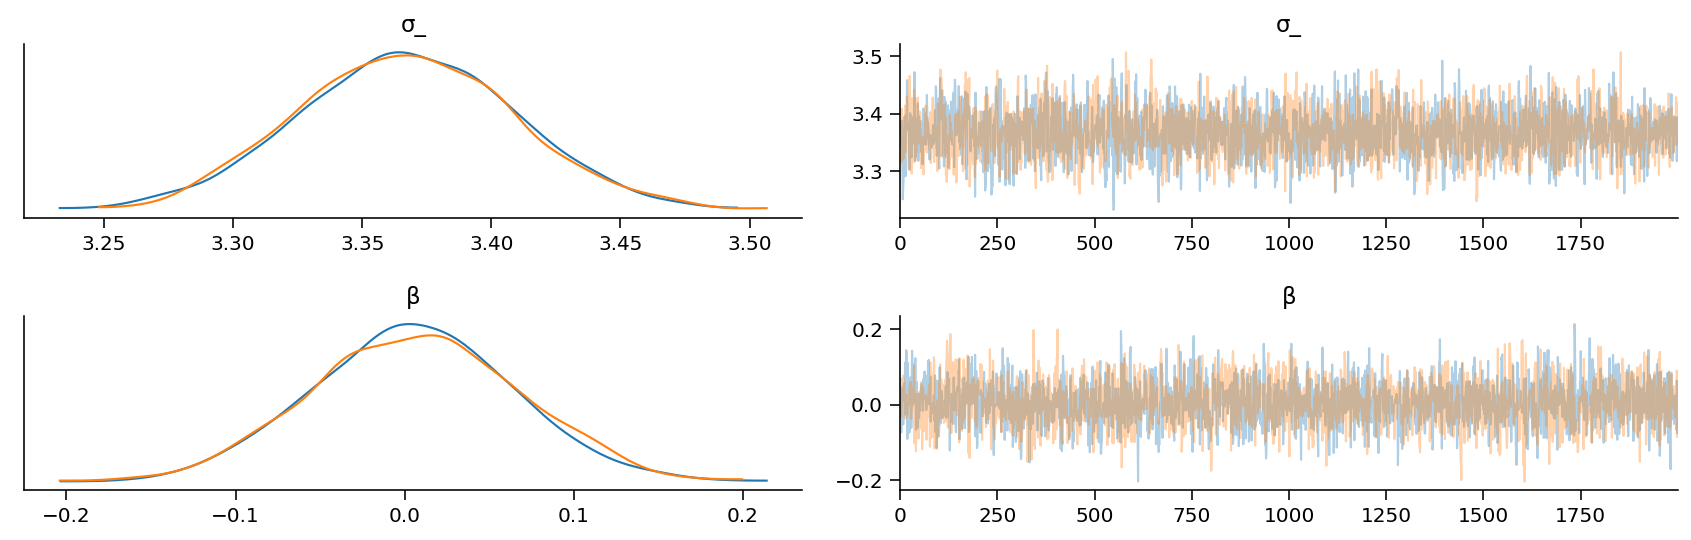

In [ ]:
# @title Trace inspection
model_wo.plot("trace", var_names =  ['σ_', 'β'])
# model_wr.plot("trace", var_names =  ['σ_', 'β_standing', 'β_running'])

The sampler experienced 0 divergences in all chains of both models. This suggests it converged to a similar posterior in all chains. It did not get stuck in any region of the parameter space.

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  func(*args, **kwargs)


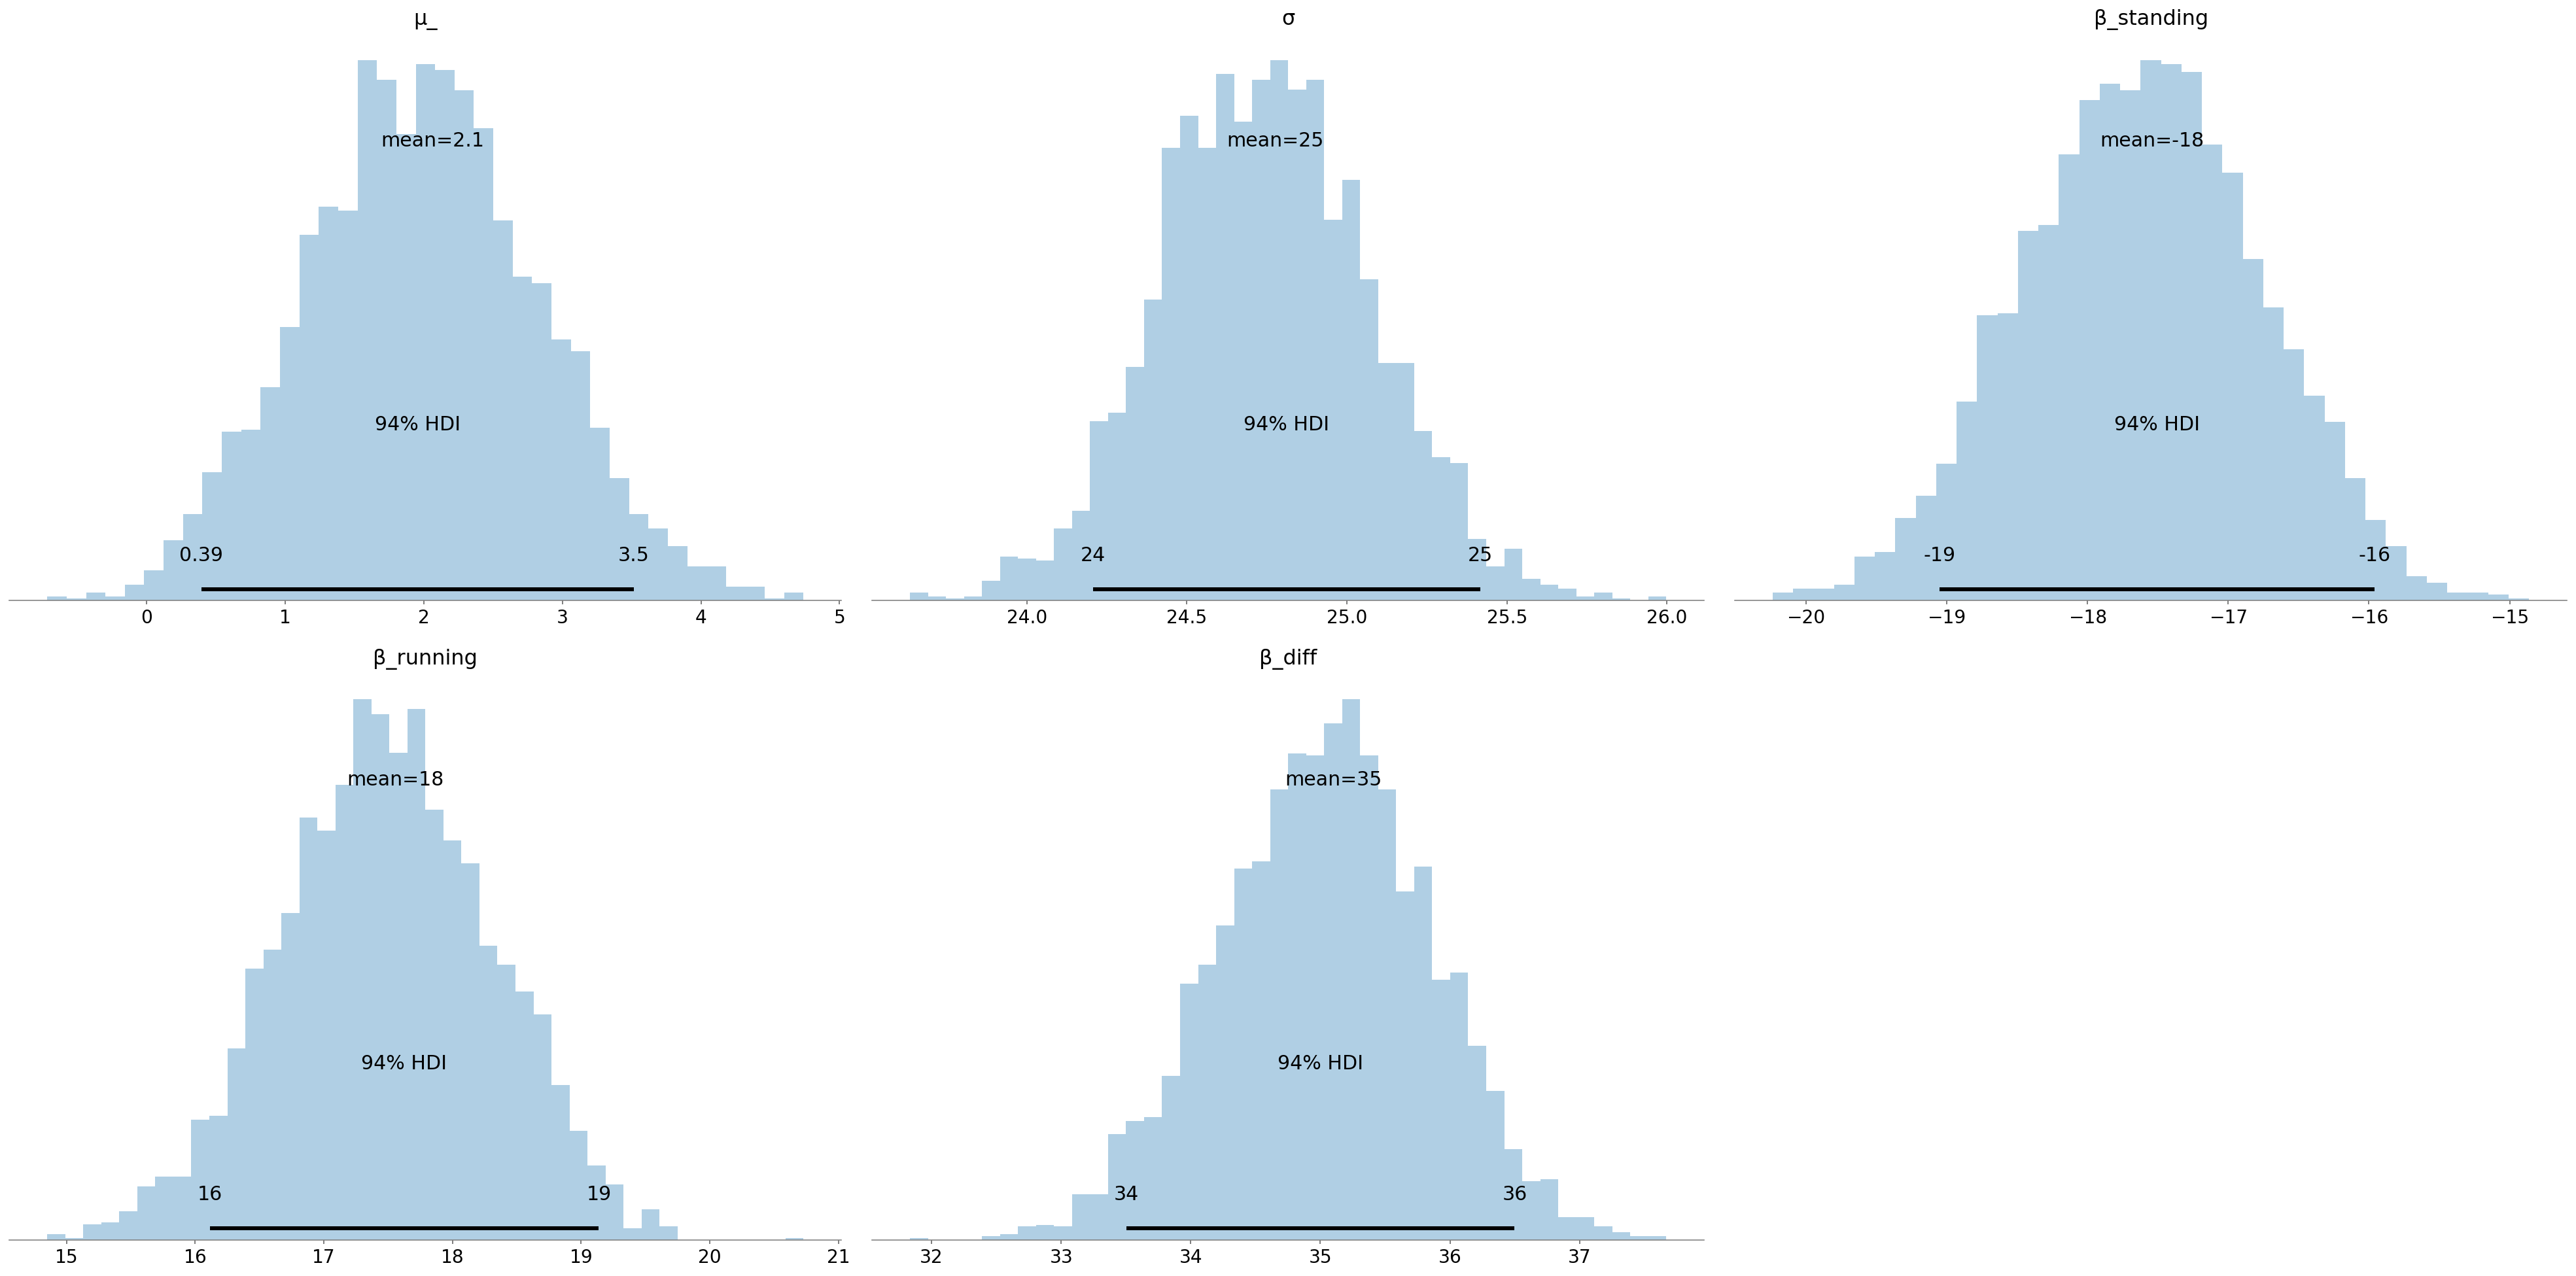

In [ ]:
# @title Estimated posterior distribution paramters when no running effect is assumed
with model_simple._model:
  pm.plots.plot_posterior(model_simple._trace, var_names = ['μ_', 'σ', 'β_standing', 'β_running', 'β_diff'], kind='hist')

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  func(*args, **kwargs)


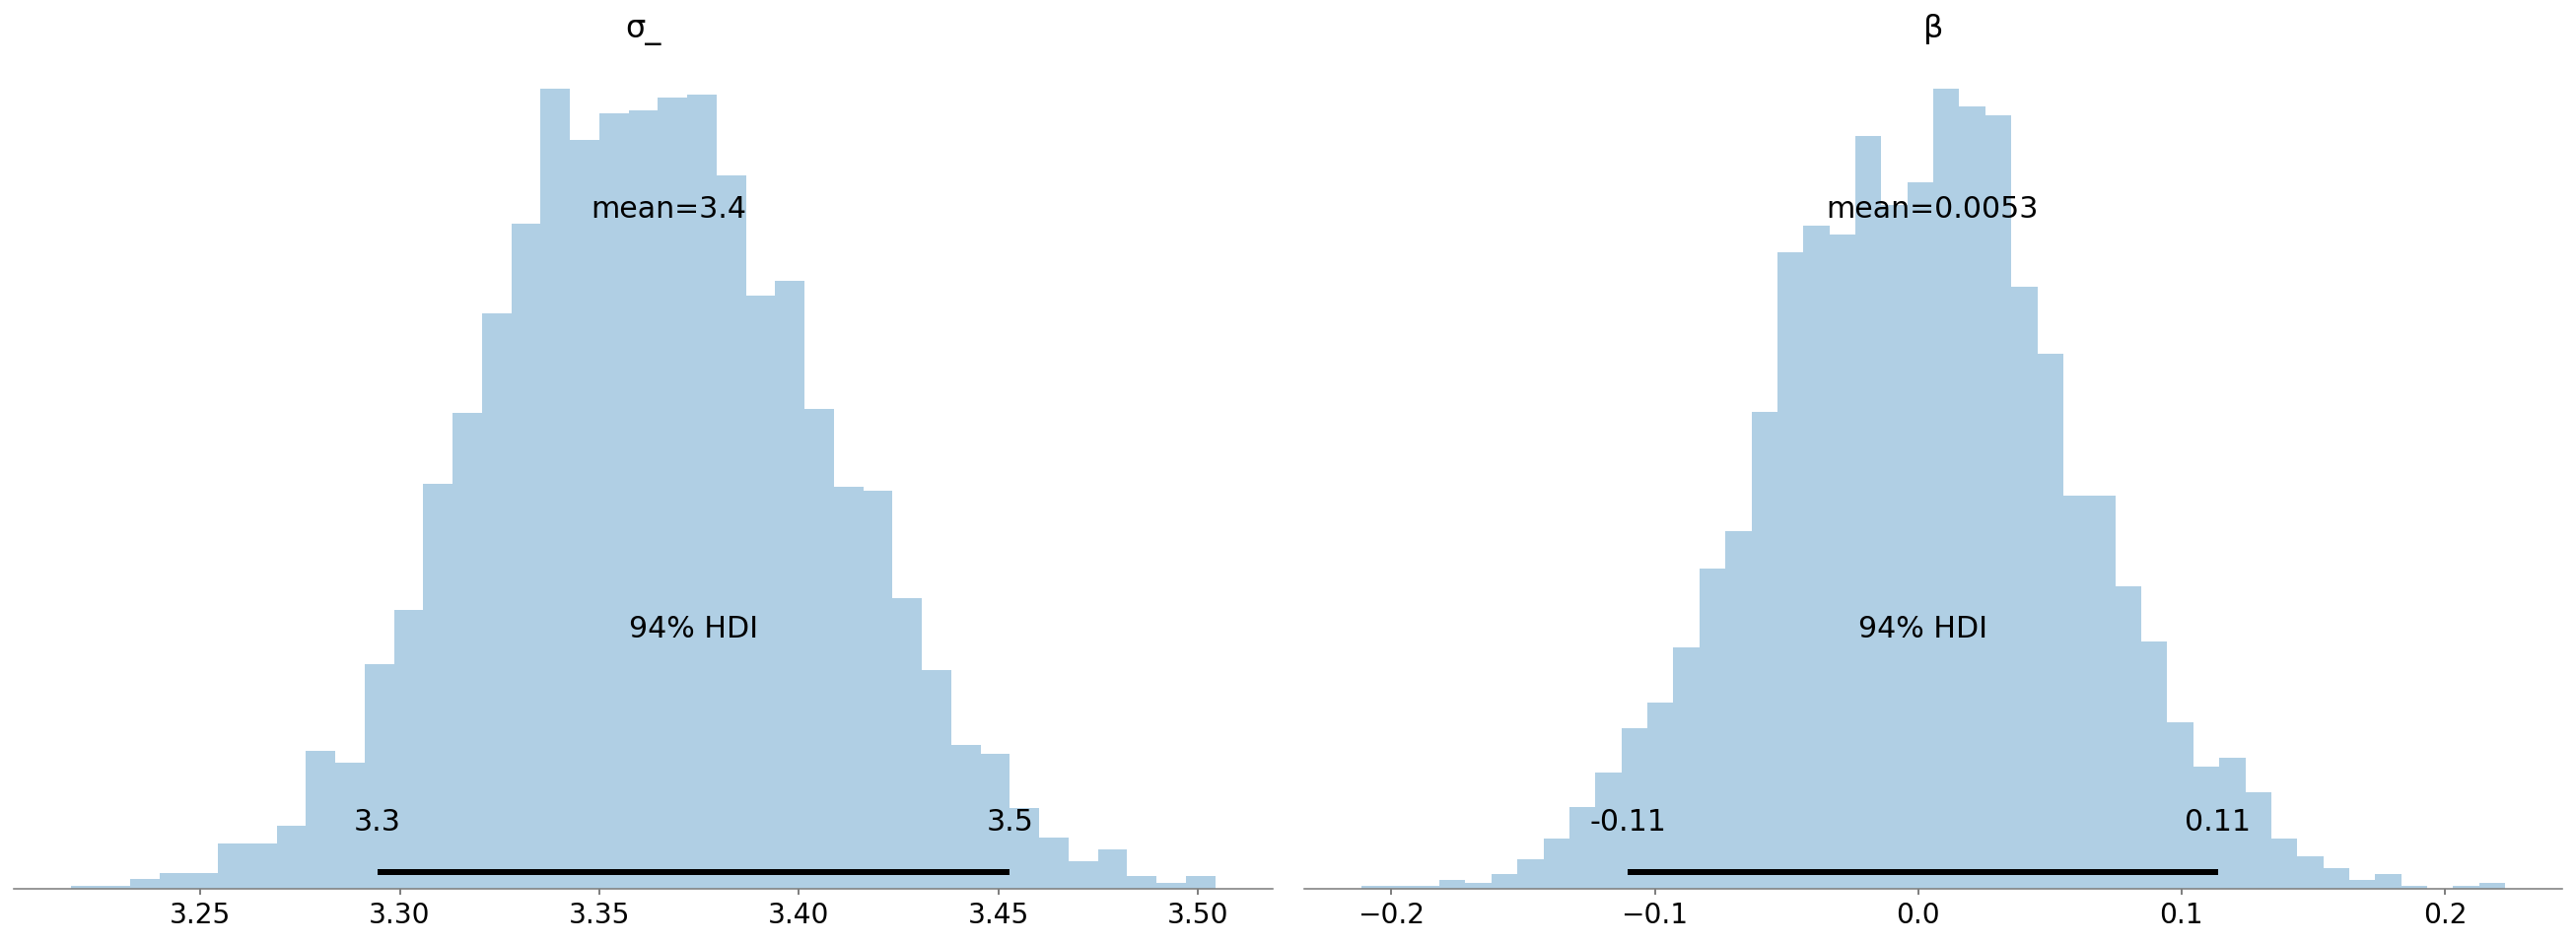

In [ ]:
# @title Estimated posterior distribution parameters when no running effect is assumed
with model_wo._model:
  pm.plots.plot_posterior(model_wo._trace, var_names =  ['σ_', 'β'],  kind='hist')

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  func(*args, **kwargs)


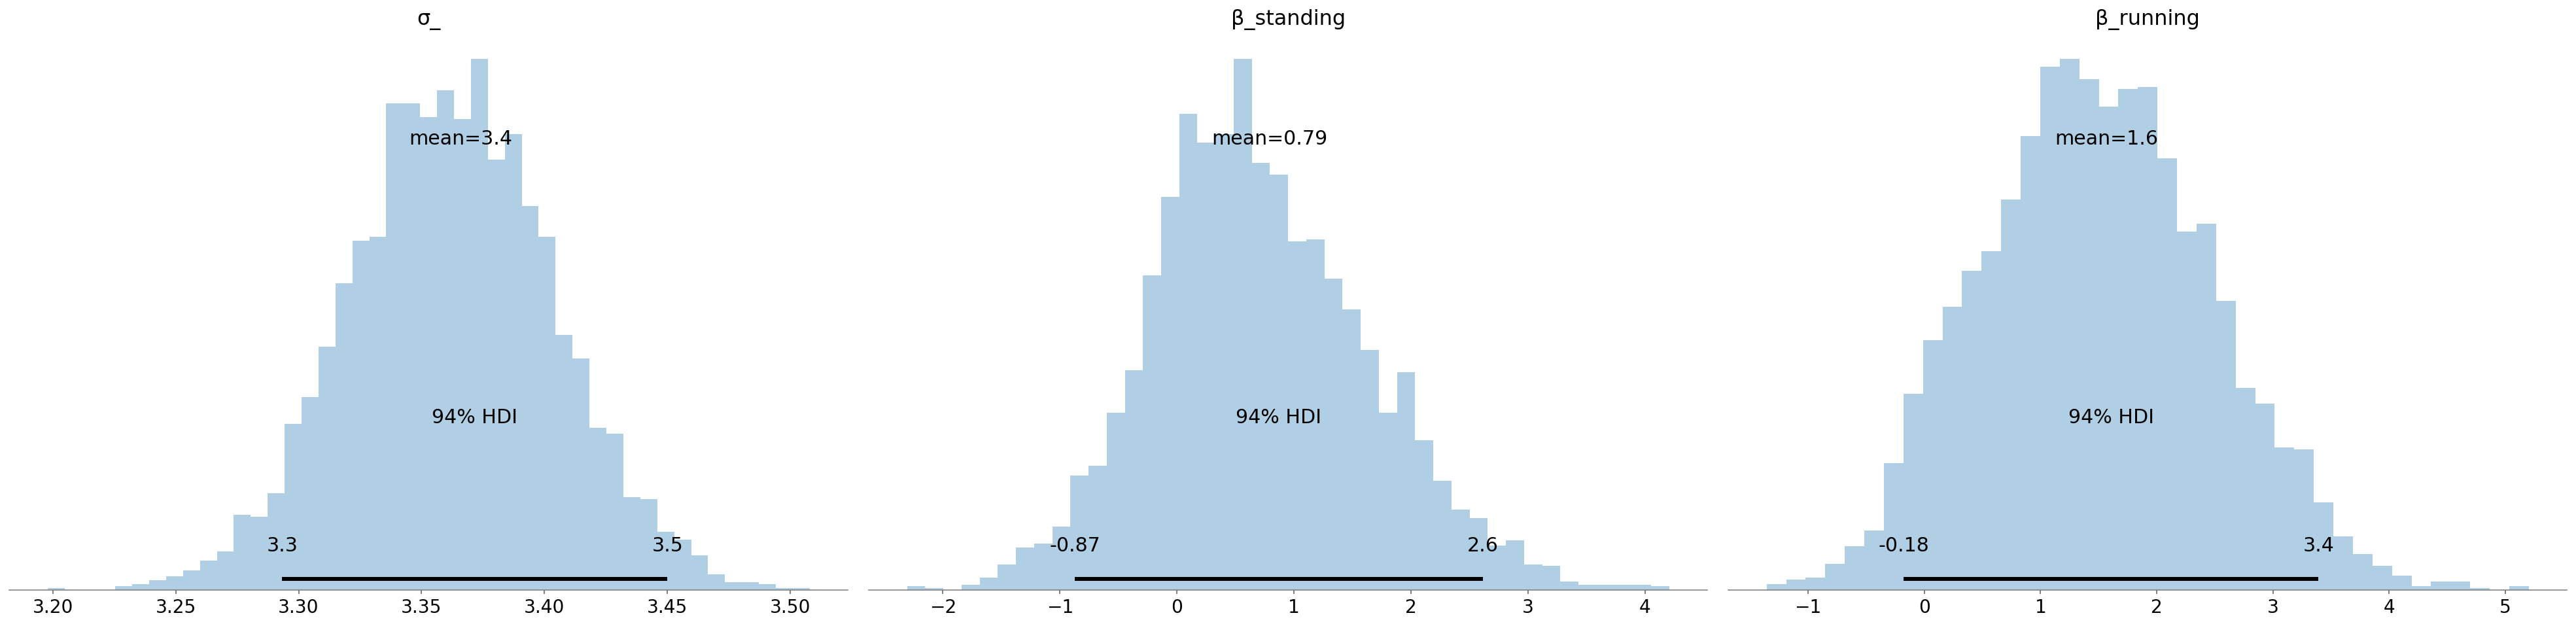

In [ ]:
# @title Estimated posterior distribution paramters when a multiplicative running effect is assumed
with model_wr._model:
    pm.plots.plot_posterior(model_wr._trace, var_names = ['σ_', 'β_standing', 'β_running'], kind='hist')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  func(*args, **kwargs)


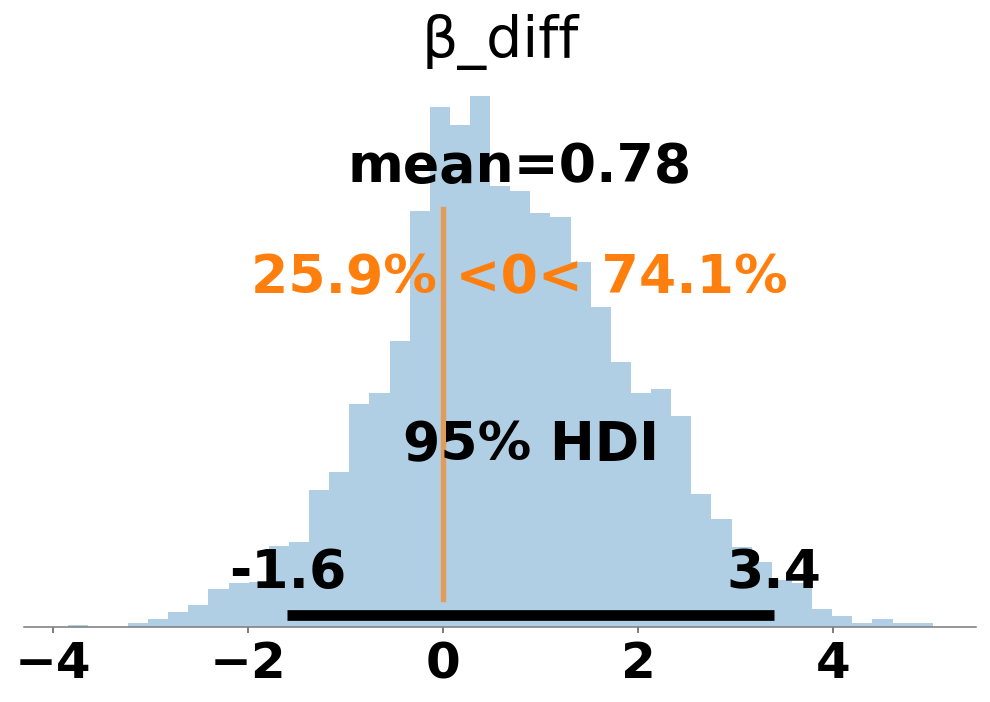

In [ ]:
# @title Estimated differental effect posterior distribution

with model_wr._model:
    ax = pm.plots.plot_posterior(model_wr._trace, var_names = ['β_diff'], kind='hist', ref_val=0, hdi_prob=0.95, textsize=25)

This plot tells us that a running mouse will on average have an extra 78% of μ (the baseline activity) compared to what the standing mouse would. However, there is a lot of uncertainty regarding the estimate, to the point where it takes negative values within the high density probability interval. This is already a sign that the model is not capturing the variance well enough and instead it's considering it noise (hence the increased uncertainty).

In [ ]:
y_wo = pm.sample_posterior_predictive(model_wo._trace, 2000, model=model_wo._model)['y_pred']
y_wr = pm.sample_posterior_predictive(model_wr._trace, 2000, model=model_wr._model)['y_pred']

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:26<00:00, 74.31it/s]


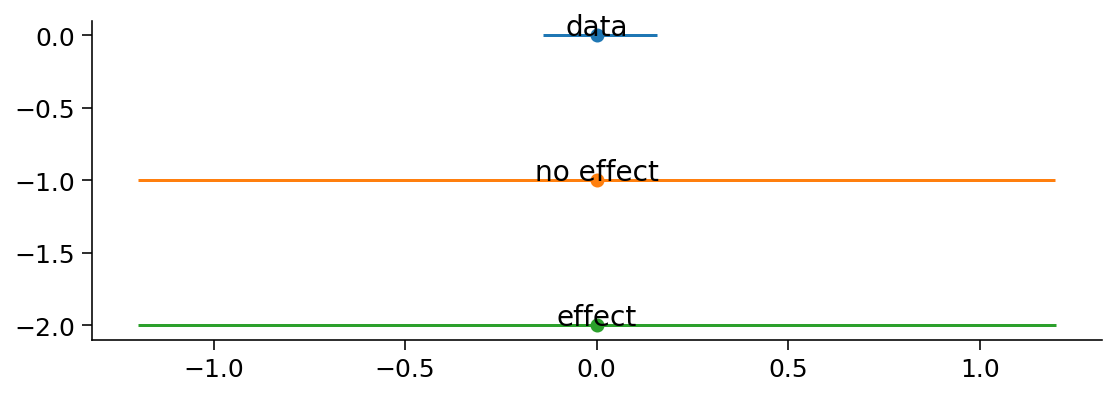

In [ ]:
plt.figure(figsize=(8, 3))
data = [model_wo.response, y_wo, y_wr]
labels = ["data", "no effect", "effect"]
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75]) * np.array([-1, 1])
    err = err.reshape((2, 1))
    plt.errorbar(mean, -i, xerr=err, fmt = 'o')
    plt.text(mean, -i, labels[i], ha='center', fontsize=14)

This plot draws inspiration from one of the posterior predictive checks done in Bayesian Analysis with Python Chapter 5 https://github.com/aloctavodia/BAP/blob/master/code/Chp5/05_Model_comparison.ipynb. It aims to show how similar the mean and the variance of the actual data and the simulated data (based on the estimated posteriors) look like. The mean is captured very well, but again we see the simulated data exhibits much more noise than the real data, indicating there are some patterns the model did not capture well.

[[<matplotlib.axis.XTick at 0x7f39ccb3f3c8>,
 [Text(0, 0, 'data'), Text(0, 0, 'no effect'), Text(0, 0, 'effect')]]

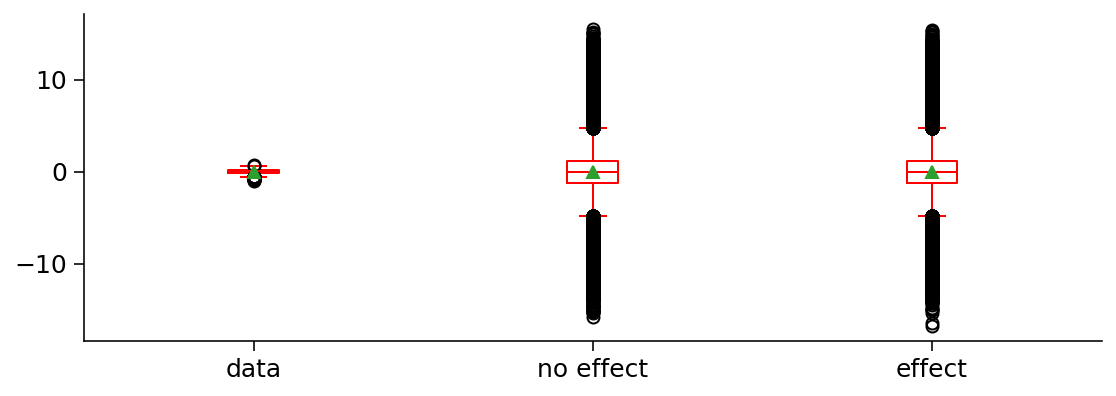

In [ ]:
plt.figure(figsize=(8, 3))
data = [model_wo.response.flatten(), y_wo.flatten(), y_wr.flatten()]
labels = ["data", "no effect", "effect"]
ax = plt.gca()
for i in range(len(data)):
  bp = ax.boxplot(data[i], showmeans=True, positions=[i])
  for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
      plt.setp(bp[item], color="red")

ax.set(xticks=[0, 1,2], xticklabels=labels)

This plot shows the same as the previous one but in a different way, which a more familiar boxplot

In [ ]:
pm.stats.summary(model_wr._trace, var_names = ['σ_', 'β_standing', 'β_running'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
σ_          3.367  0.043   3.287    3.444  ...  2954.0    2994.0    2612.0    1.0
β_standing  0.779  0.915  -0.942    2.478  ...  1691.0    2491.0    2330.0    1.0
β_running   1.567  1.042  -0.258    3.540  ...  1529.0    1500.0    2481.0    1.0

[3 rows x 11 columns]

In [ ]:
cmp_df = az.compare({'model_wo': model_wo._trace, 'model_wr': model_wr._trace}, method = 'BB-pseudo-BMA')

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posteri

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  func(*args, **kwargs)


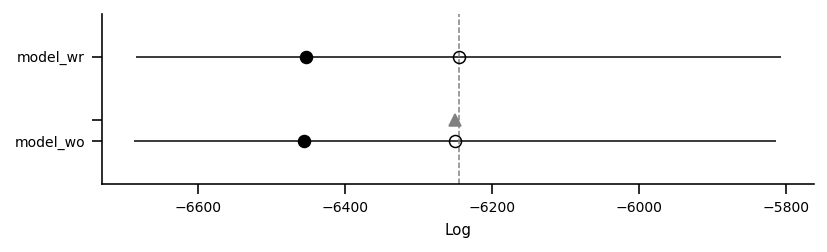

In [ ]:
az.plot_compare(cmp_df)

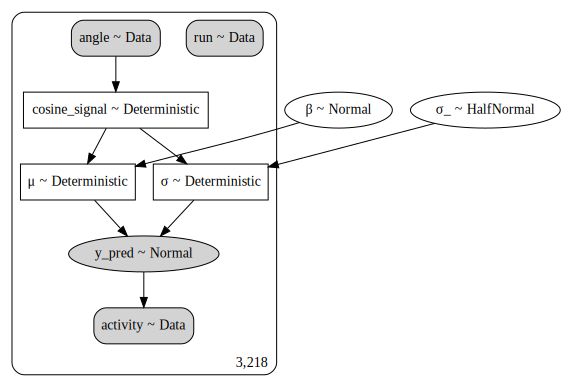

In [ ]:
pm.model_to_graphviz(model_wo._model)

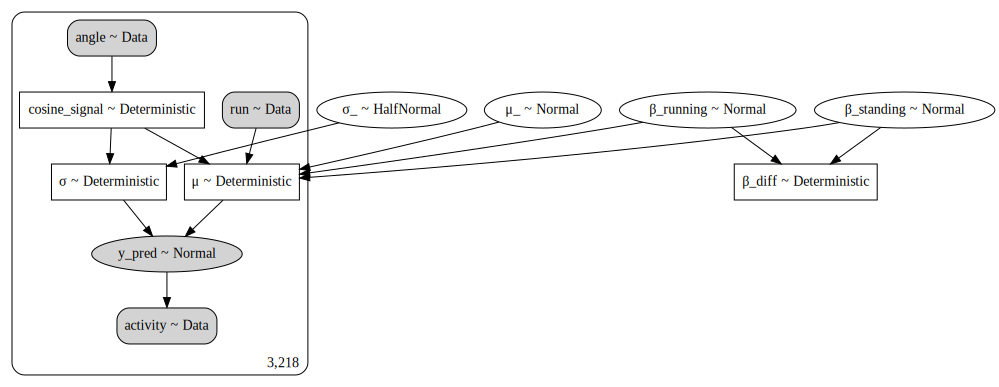

In [ ]:
pm.model_to_graphviz(model_wr._model)